In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import matplotlib.pyplot as plt
from utils import create_directory, plot_simulations, plot_training_log
import json


In [2]:
import motornet as mn
from task import CentreOutFF
from policy import Policy
import torch as th
import numpy as np

In [3]:
data_dir = create_directory('2023-09-26')
model_num = 1

weight_file = os.path.join(data_dir, f"model{model_num}_weights")
log_file = os.path.join(data_dir, f"model{model_num}_log.json")
cfg_file = os.path.join(data_dir, f"model{model_num}_cfg.json")

Directory '/Users/mahdiyarshahbazi/Documents/Data/2023-09-26' already exists.


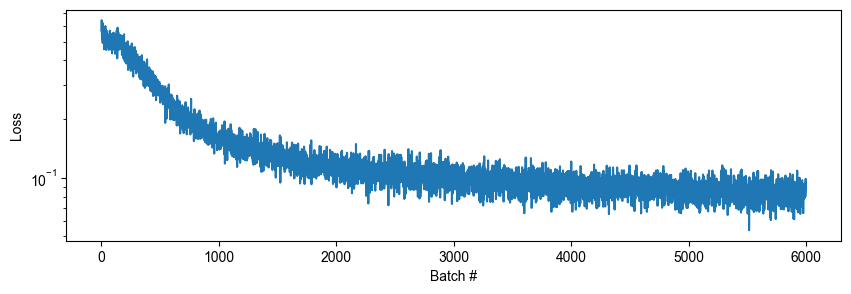

In [6]:
# retrieve and plot training history
with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

fig = plt.figure(figsize=(10,3))
plt.rcParams['font.family'] = "Arial"
ax = plot_training_log(log=loaded_training_log)
fig.savefig(data_dir+f'/model{model_num}_loss.pdf',bbox_inches='tight')

In [ ]:
env2 = MyCustomEnv(effector=mn.effector.RigidTendonArm26(muscle=mn.muscle.ReluMuscle()),max_ep_duration=1.,name='env')
policy2 = Policy(env2.observation_space.shape[0], 32, env2.n_muscles, device=device)
policy2.load_state_dict(th.load(weight_file))

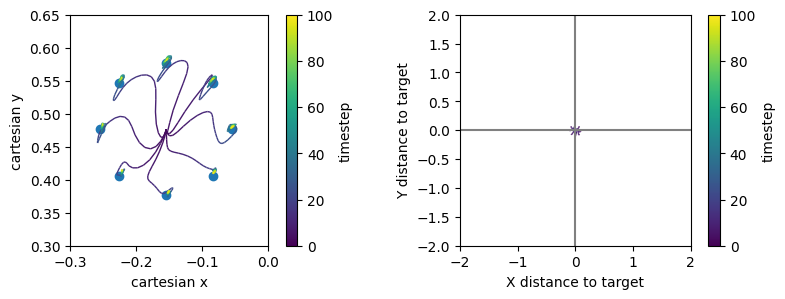

In [64]:
# ==========
# Evaluation
# ==========
batch_size = 8
# initialize batch
h = policy2.init_hidden(batch_size=batch_size)
obs, info = env2.reset(condition = "test", options={'batch_size':batch_size})
terminated = False

# initial positions and targets
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
  action, h = policy2(obs, h)
  obs, reward, terminated, truncated, info = env2.step(action=action)

  xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
  tg.append(info["goal"][:, None, :])  # targets

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))

plot_simulations(xy=xy, target_xy=tg)
